In [ ]:
!wget https://nlp.stanford.edu/software/stanford-parser-full-2018-10-17.zip
!unzip stanford-parser-full-2018-10-17.zip
!unzip stanford-parser-full-2018-10-17/stanford-parser-3.9.2-models.jar
!pip3 install nltk

--2021-12-23 06:02:50--  https://nlp.stanford.edu/software/stanford-parser-full-2018-10-17.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://downloads.cs.stanford.edu/nlp/software/stanford-parser-full-2018-10-17.zip [following]
--2021-12-23 06:02:51--  https://downloads.cs.stanford.edu/nlp/software/stanford-parser-full-2018-10-17.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 641564462 (612M) [application/zip]
Saving to: ‘stanford-parser-full-2018-10-17.zip.1’

stanford-parser-ful 100%[===================>] 611.84M  5.10MB/s    in 2m 0s   

2021-12-23 06:04:51 (5.10 MB/s) - ‘stanford-parser-full-2018-10-17.zip.1’ saved [641564462/64

In [2]:
from nltk.parse.stanford import StanfordParser

parser = StanfordParser(
    model_path="edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz",
    path_to_jar="stanford-parser-full-2018-10-17/stanford-parser.jar",
    path_to_models_jar="stanford-parser-full-2018-10-17/stanford-parser-3.9.2-models.jar"
)



```
# 此内容为代码格式
```

I think Andre said the Jamaica Observer reported that Usain Bolt broke the 100m record



In [5]:
next(parser.raw_parse('The hyppopotamus sat on a cat'))

TclError: ignored

Tree('ROOT', [Tree('S', [Tree('NP', [Tree('DT', ['The']), Tree('NNS', ['hyppopotamus'])]), Tree('VP', [Tree('VBD', ['sat']), Tree('PP', [Tree('IN', ['on']), Tree('NP', [Tree('DT', ['a']), Tree('NN', ['cat'])])])])])])

In [ ]:
import matplotlib.pyplot as plt

DY = 5
EPS = 1
YMAX = 101
ymin = 100
xmax = 100
leaf_num = 0

class DrawableTree:
    def __init__(self, root, is_leaf=False, x=0, y=100, num_tokens=None):
        self.y = y
        self.x = x
        self.num_tokens = num_tokens or len(root.split())
        self.is_leaf = is_leaf
        
        if isinstance(root, str):
            if self.is_leaf:
                global leaf_num
                self.is_odd = bool(leaf_num % 2)
                leaf_num += 1
                
                self.subtrees = []
                self.label = root
                self.width = len(self.label)
                self.dlabel = self._dlabel()
                return
            else:
                root = next(parser.raw_parse(root))
        
        self.label = root.label()
        self.dlabel = self._dlabel()
        self.subtrees = []
        for i, node in enumerate(root):
            self.subtrees.append(
                DrawableTree(
                    node,
                    is_leaf=isinstance(node, str),
                    x=self.x,
                    y=self.y-DY,
                    num_tokens=self.num_tokens
                )
            )
        
        if self.subtrees:
            self._update_subtrees()
        self.width = self._get_sum_subtree() + EPS
    
    def _dlabel(self):
        return len(self.label) / 2
    
    def _update_subtrees(self):
        self.max_subtree = self._get_max_subtree()
        if len(self.subtrees) == 1:
            self.subtrees[0].x = 0
        else:
            min_x = -len(self.subtrees) / 2 * 0.9
            max_x = len(self.subtrees) / 2 * 0.9
            for i, subtree in enumerate(self.subtrees):
                subtree.x = (self.max_subtree * (min_x + i * (max_x - min_x) / (len(self.subtrees) - 1)))
    
    def _get_max_subtree(self):
        return max([tree.width for tree in self.subtrees])
    
    def _get_sum_subtree(self):
        return sum([tree.width for tree in self.subtrees])
        
    def draw(self, dx=0):
        eps = EPS * (1 - int(self.is_odd)) if self.is_leaf else EPS / 2
        plt.text(dx-self.dlabel, self.y - eps, self.label)
        
        global ymin, xmax
        ymin = min(ymin, self.y-EPS)
        xmax = max(xmax, abs(dx+self.dlabel))
        
        for subtree in self.subtrees:
            plt.plot((dx, subtree.x+dx), (self.y-EPS, subtree.y+EPS))
            subtree.draw(dx+subtree.x)
            
def visualize(text):
    plt.rcParams["figure.figsize"] = [15, 6]
    plt.clf()
    
    graph = DrawableTree(text)
    graph.draw()

    plt.ylim([ymin, YMAX])
    plt.xlim([-xmax, xmax])

    plt.axis('off')
    
    plt.show()

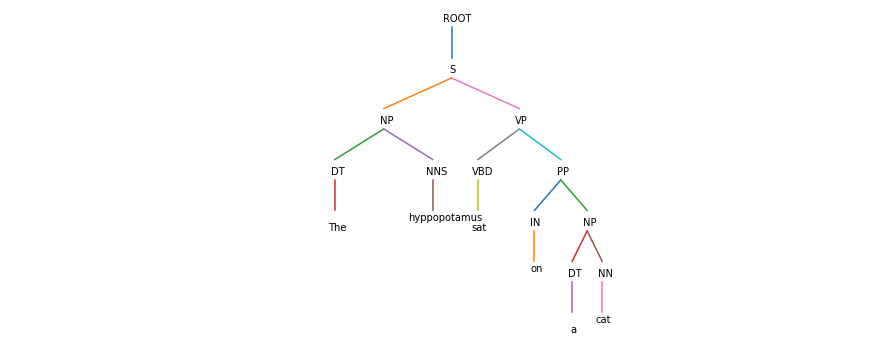

In [ ]:
visualize('The hyppopotamus sat on a cat')

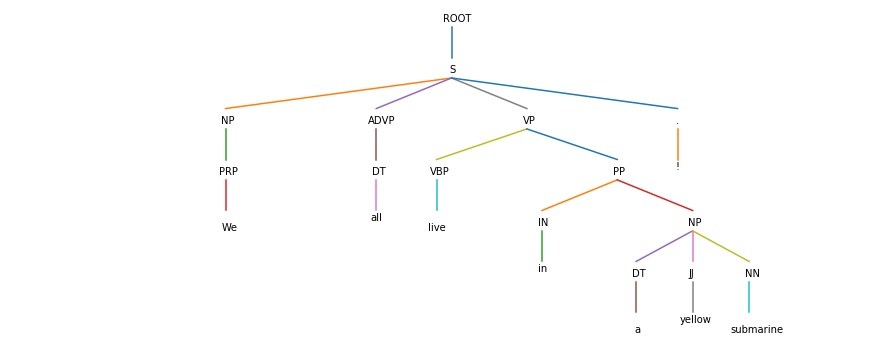

In [ ]:
visualize('We all live in a yellow submarine!')

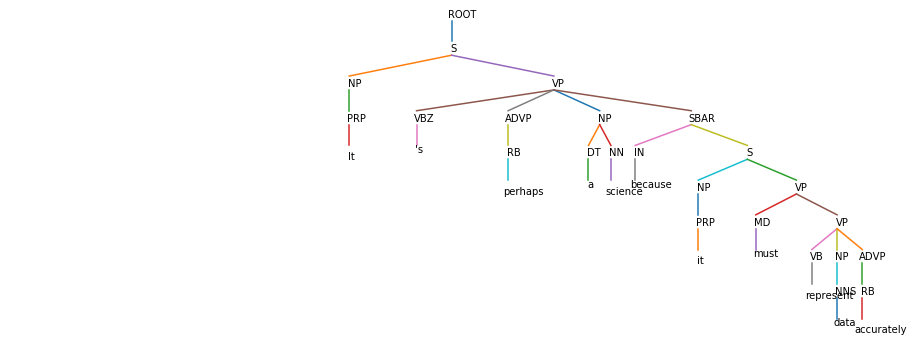

In [ ]:
visualize('It’s perhaps a science because it must represent data accurately')

В принципе, получилось.

Основная проблема -- средствами matplotlib я не могу заранее задать размер (в терминах координат) бокса с текстом, потому что текст для пользователя рендерится фиксированного размера. Но до построения дерева я не могу узнать, какого размера оно будет (и каково будет соотношение размера текста к размеру холста), а для его построения мне нужно знать, какого размера будут листья с текстом. Кажется, это логический тупик :)

Поэтому, когда предложения становятся больше и содержат длинные слова, есть шанс коллизий блоков текста и проблем с читаемостью. Проблема кое-как решается с помощью чередования уровней слов в листьях ()